# Importing Libraries

In [1]:
import numpy as np

import torch
print(torch.__version__)

import matplotlib.pyplot as plt
torch.cuda.is_available()

2.0.1


True

Setup device agnostic code 

In [2]:
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(f"Current used device is: {DEVICE}")

Current used device is: cuda


# Getting Data 

- The dataset used in this project is part of [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). 
  - *Food101* is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).
- The cutomized dataset contains only three classes  pizza, steak and sushi with 10% of each class
  - [data/pizza_steak_sushi.zip](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip)

Let's first download the data from github to local folder

In [3]:
import requests
import zipfile
import pathlib

DATA_PATH = pathlib.Path("data/")
IMAGE_PATH = DATA_PATH / "pizza_steak_sushi"

# Making data directories
if DATA_PATH.is_dir():
    print(f"{DATA_PATH} directory is already exists.")
else:
    print(f"Creating new directory {DATA_PATH} ...")
    IMAGE_PATH.mkdir(parents=True, exist_ok=True)

if not ((DATA_PATH / "pizza_steak_sushi.zip").is_file()):
    # Downloading data locally
    with open(DATA_PATH / "pizza_steak_sushi.zip", 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Extract images from the zip file
    with zipfile.ZipFile(DATA_PATH / "pizza_steak_sushi.zip", 'r') as zip_f:
        print("Extracting pizza, steak, sushi data...")
        zip_f.extractall(IMAGE_PATH)

data directory is already exists.


Let's explor the directories and files

In [4]:
import os

for dirpath, dirnames, filenames in os.walk(IMAGE_PATH):
    print (f"root {dirpath}: There are {len(dirnames)} directories, and {len(filenames)} files")

root data\pizza_steak_sushi: There are 2 directories, and 0 files
root data\pizza_steak_sushi\test: There are 3 directories, and 0 files
root data\pizza_steak_sushi\test\pizza: There are 0 directories, and 25 files
root data\pizza_steak_sushi\test\steak: There are 0 directories, and 19 files
root data\pizza_steak_sushi\test\sushi: There are 0 directories, and 31 files
root data\pizza_steak_sushi\train: There are 3 directories, and 0 files
root data\pizza_steak_sushi\train\pizza: There are 0 directories, and 78 files
root data\pizza_steak_sushi\train\steak: There are 0 directories, and 75 files
root data\pizza_steak_sushi\train\sushi: There are 0 directories, and 72 files


Load the data using dataset, dataloader and apply transformations

In [5]:
# Define transformations operations to be applied for each image
from torchvision import transforms
from torchvision import datasets

data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(root= IMAGE_PATH / "train",
                                     transform= data_transform,
                                     target_transform=None)

test_dataset = datasets.ImageFolder(root= IMAGE_PATH / "test",
                                     transform= data_transform,
                                     target_transform=None)

print(f'Train size: {len(train_dataset)}\nTest Size: {len(test_dataset)}')

Train size: 225
Test Size: 75


# Data Exploration and Analysis

Show Image Example

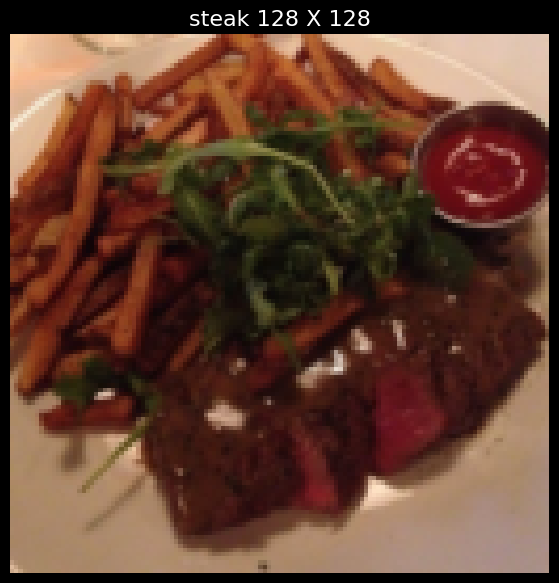

In [6]:
import PIL
import random

def plot_rand_img():
    idx = random.randint(0, len(train_dataset))
    img, label = train_dataset[idx]
    plt.figure(figsize=(10, 7))
    plt.imshow(img.permute(1,2,0))
    plt.title(f"{train_dataset.classes[label]} {img.shape[1]} X {img.shape[1]}", fontsize=16)
    plt.axis('off')
    plt.show()

plot_rand_img()

In [7]:
print(f'Classe:{train_dataset.classes}')

Classe:['pizza', 'steak', 'sushi']


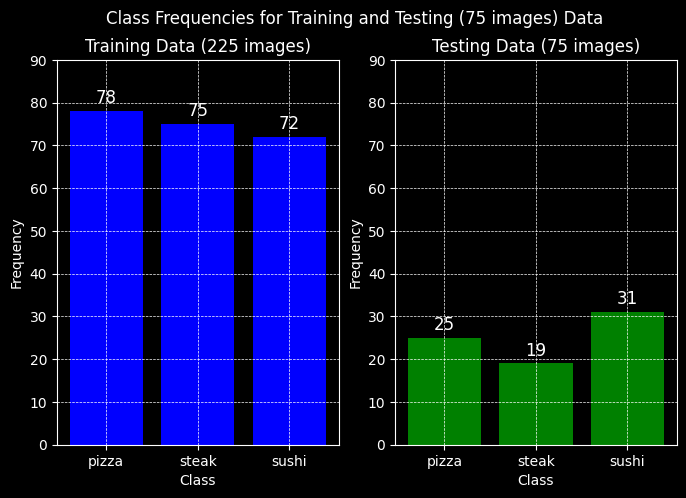

In [8]:
# TODO plot historgram to the frequency of each class
from collections import Counter, OrderedDict
train_class_freq = OrderedDict(Counter(train_dataset.targets))
test_class_freq = OrderedDict(Counter(test_dataset.targets))

def plot_classes_freq(axes_idx, classes, freqs, color, title):
    plt.subplot(1,2,axes_idx)

    bars1 = plt.bar(classes, freqs, color= color)
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.ylim((0,90))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title(title)
    for bar in bars1:
        height = bar.get_height()
        plt.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12)
 
plt.figure(figsize=(8,5))

plot_classes_freq(1, train_dataset.classes, train_class_freq.values(), 'blue', f'Training Data ({len(train_dataset)} images)')
plot_classes_freq(2, test_dataset.classes, test_class_freq.values(), 'green', f'Testing Data ({len(test_dataset)} images)')

plt.suptitle(f"Class Frequencies for Training and Testing ({len(test_dataset)} images) Data ")
plt.show()

# Build model

Here we are using VGG architecture to experiment

In [9]:
from torch import nn 

class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels= hidden_units, out_channels= 2*hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= 2*hidden_units, out_channels= 2*hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2*hidden_units*2*hidden_units*2*hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        x = self.block1(x)
        # print(f"Shape after block1: {x.shape}")
        x = self.block2(x)
        # print(f"Shape after block2: {x.shape}")
        x = self.classifier(x)
        # print(f"Shape after classifier: {x.shape}")
        return x


Creating model instance

In [10]:
torch.manual_seed(42)

model = TinyVGG(input_shape=3, hidden_units=16, output_shape=3).to(DEVICE)

model

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=3, bias=True)
  )
)

Get the summary of the model using torchinfo

In [11]:
try:
    import torchinfo
except:
    %pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       448
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       2,320
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       4,640
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       9,248
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      98,307
Total params: 114,963
Trainable params: 114,963
Non-trainable params: 0

Testing model with one image

In [12]:
img, label = train_dataset[0]
img = torch.unsqueeze(img,dim=0)
print(f'single input shape:{img.shape}')

model.eval()
with torch.inference_mode():
    pred_logits = model(img.to(DEVICE))

print(f"Output logits shape: {pred_logits.shape}\n")
print(f"Output prediction probabilities: \n{torch.softmax(pred_logits, dim=1)}\n")
print(f"Output prediction label: {torch.argmax(torch.softmax(pred_logits, dim=1), dim=1).item()}\n")
print(f"Actual label: {label}")

single input shape:torch.Size([1, 3, 128, 128])
Output logits shape: torch.Size([1, 3])

Output prediction probabilities: 
tensor([[0.3327, 0.3347, 0.3327]], device='cuda:0')

Output prediction label: 1

Actual label: 0


# Model Training

## Prepare data
    - Define data loader with batch size

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset= train_dataset,
                              batch_size= 32,
                              shuffle= True)

test_dataloader = DataLoader(dataset= train_dataset,
                              batch_size= 32,
                              shuffle= False)

img_batch, labels_batch = next(iter(train_dataloader))
img_batch.shape, labels_batch.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

## Train the model

In [14]:
def train_step(model, train_dataloader, optimizer, loss_fn):
    '''This function do training epoch by going through all batches and update weights'''
    model.to(DEVICE)
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_dataloader):
        # move data to the devic (CPU or GPU)
        X, y = X.to(DEVICE), y.to(DEVICE)

        # Forward pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # optimizer Zero gradient
        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

        # calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    return train_loss, train_acc

In [15]:
def test_step(model, test_dataloader, loss_fn):

    model.to(DEVICE)

    model.eval()
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            # move data to the devic (CPU or GPU)
            X, y = X.to(DEVICE), y.to(DEVICE)

            # Forward pass
            y_pred = model(X)

            # Calculate the loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # calculate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(y_pred)

    test_loss = test_loss / len(train_dataloader)
    test_acc = test_acc / len(train_dataloader)
    return test_loss, test_acc

In [16]:
try:
    from tqdm.auto import tqdm
except:
    %pip install tqdm
    from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, optimizer, loss_fn)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

Now its the time for training :)

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

model = TinyVGG(input_shape=3, hidden_units=16, output_shape=3)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

from timeit import default_timer as timer 

start_time = timer()

model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f'Total elapsed time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1149 | train_acc: 0.3281 | test_loss: 1.0773 | test_acc: 0.4570
Epoch: 2 | train_loss: 1.0822 | train_acc: 0.3555 | test_loss: 0.9477 | test_acc: 0.5742
Epoch: 3 | train_loss: 0.9675 | train_acc: 0.6367 | test_loss: 0.9223 | test_acc: 0.5000
Epoch: 4 | train_loss: 0.8681 | train_acc: 0.6133 | test_loss: 0.7943 | test_acc: 0.6914
Epoch: 5 | train_loss: 0.7872 | train_acc: 0.6641 | test_loss: 0.7468 | test_acc: 0.6680
Epoch: 6 | train_loss: 0.7087 | train_acc: 0.6875 | test_loss: 0.7332 | test_acc: 0.6719
Epoch: 7 | train_loss: 0.7469 | train_acc: 0.7266 | test_loss: 0.6871 | test_acc: 0.7422
Epoch: 8 | train_loss: 0.6964 | train_acc: 0.6875 | test_loss: 0.6971 | test_acc: 0.7148
Epoch: 9 | train_loss: 0.7331 | train_acc: 0.7031 | test_loss: 0.6964 | test_acc: 0.6953
Epoch: 10 | train_loss: 0.7272 | train_acc: 0.7500 | test_loss: 0.6286 | test_acc: 0.7578
Total elapsed time: 21.553 seconds


# Model Evaluation

## Loss and Accuracy Curves

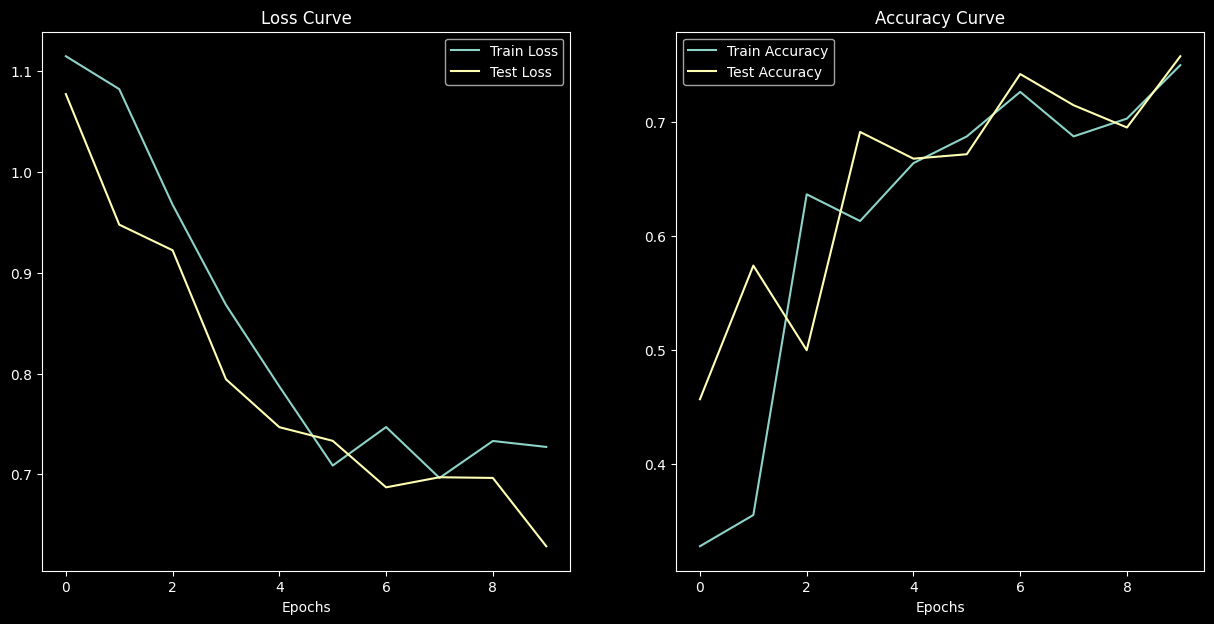

In [18]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(range(NUM_EPOCHS), model_0_results['train_loss'], label='Train Loss')
plt.plot(range(NUM_EPOCHS), model_0_results['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(NUM_EPOCHS), model_0_results['train_acc'], label='Train Accuracy')
plt.plot(range(NUM_EPOCHS), model_0_results['test_acc'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy Curve')
plt.legend()

## Make A prediction On Single Image

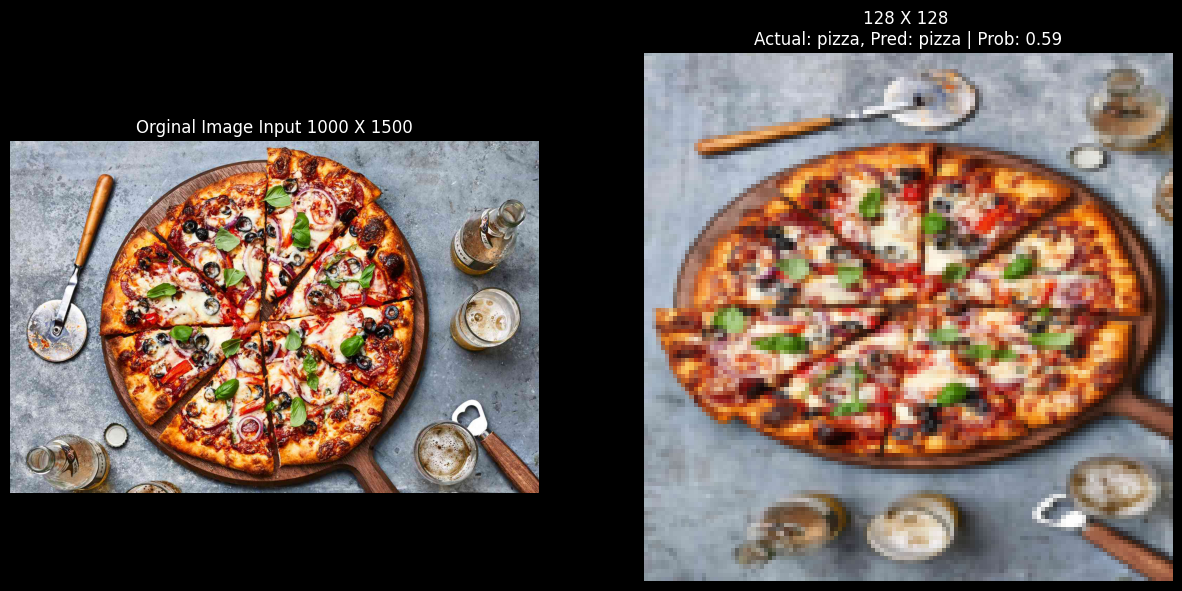

In [50]:
import PIL.Image
from torchvision import transforms
import pathlib

IMG_Path = pathlib.Path("data/1.jpg")

pred_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

img = PIL.Image.open(IMG_Path)
transformed_img =pred_transform(img)

# transformed_img.shape

model.eval()
with torch.inference_mode():
    y_pred = model(transformed_img.unsqueeze(dim=0).to(DEVICE))
   
    y_probs = torch.softmax(y_pred, dim=1)

    y_pred_label =  torch.argmax(y_probs, dim=1)
    
    pred_class = train_dataset.classes[y_pred_label.item()]

    # Visualize
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis(False)
    plt.title(f"Orginal Image Input {img.height} X {img.width}")

    plt.subplot(1,2,2)
    plt.imshow(transformed_img.permute(2,1,0))
    plt.axis(False)
    plt.title(f"{transformed_img.shape[1]} X {transformed_img.shape[2]} \nActual: pizza, Pred: {pred_class} | Prob: {y_probs.max():.2f}")